# Image classification from scratch

**Author:** fchollet  
**Date created:** 2020/04/27  
**Last modified:** 2023/11/09  
**Description:** Training an image classifier from scratch on the Kaggle Cats vs Dogs dataset.

## Introduction

This example shows how to do image classification from scratch, starting from JPEG image files on disk, without leveraging pre-trained weights or a pre-made Keras Application model. We demonstrate the workflow on the Kaggle Cats vs Dogs binary classification dataset.

We use the `image_dataset_from_directory` utility to generate the datasets, and we use Keras image preprocessing layers for image standardization and data augmentation.

In [93]:
import os
from pathlib import Path
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import tensorflow as tf
import matplotlib.pyplot as plt

NOTEBOOK_DIR = Path.cwd() / "cats_vs_dogs" if not (Path.cwd() / "PetImages").exists() else Path.cwd()
DATA_DIR = NOTEBOOK_DIR / "PetImages"
ZIP_PATH = NOTEBOOK_DIR / "kagglecatsanddogs_5340.zip"

## Load the data: the Cats vs Dogs dataset

### Raw data download

First, let's download the 786M ZIP archive of the raw data:

In [94]:
if not ZIP_PATH.exists():
    !curl -L -o "{ZIP_PATH}" https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
else:
    print("Dataset zip already exists. Skipping download.")

Dataset zip already exists. Skipping download.


In [95]:
cat_dir = DATA_DIR / "Cat"
dog_dir = DATA_DIR / "Dog"
cat_count = len(list(cat_dir.glob("*"))) if cat_dir.exists() else 0
dog_count = len(list(dog_dir.glob("*"))) if dog_dir.exists() else 0

if not DATA_DIR.exists() or (cat_count + dog_count == 0):
    !unzip -oq "{ZIP_PATH}" -d "{NOTEBOOK_DIR}"
    print("Dataset extracted (or refreshed because folders were empty).")
else:
    print("PetImages folder already has data. Skipping unzip.")

!ls "{NOTEBOOK_DIR}"

PetImages folder already has data. Skipping unzip.
CDLA-Permissive-2.0.pdf    kagglecatsanddogs_5340.zip
PetImages                  readme[1].txt
app.py                     requirements.txt
cats_dogs_model.keras      save_at_1.keras
image_classification.ipynb save_at_2.keras


Now we have a `PetImages` folder which contain two subfolders, `Cat` and `Dog`. Each subfolder contains image files for each category.

In [96]:
!ls "{DATA_DIR}"

Cat Dog


## Filter out corrupted images

When working with lots of real-world image data, corrupted images are a common occurence. Let's filter out badly-encoded images that do not feature the string "JFIF" in their header.

In [97]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = DATA_DIR / folder_name
    for fname in os.listdir(folder_path):
        fpath = folder_path / fname
        if not fpath.is_file():
            continue
        try:
            raw = tf.io.read_file(str(fpath))
            tf.io.decode_image(raw, channels=3, expand_animations=False)
        except Exception:
            num_skipped += 1
            os.remove(fpath)

print(f"Deleted {num_skipped} corrupted images.")

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


Deleted 0 corrupted images.


## Generate a Dataset

In [98]:
image_size = (180, 180)
batch_size = 32  # Reduced from 128 to 32 for CPU speed

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    str(DATA_DIR),
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 24991 files belonging to 2 classes.
Using 19993 files for training.
Using 4998 files for validation.


## Visualize the data

Here are the first 9 images in the training dataset.

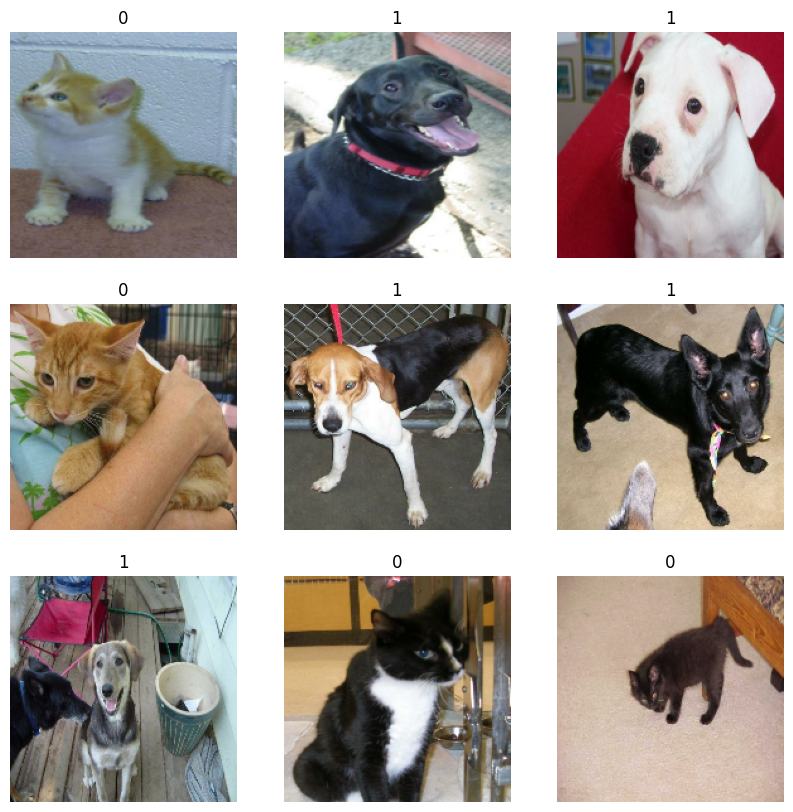

In [99]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Using image data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.

In [100]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

Let's visualize what the augmented samples look like, by applying `data_augmentation` repeatedly to the first few images in the dataset:

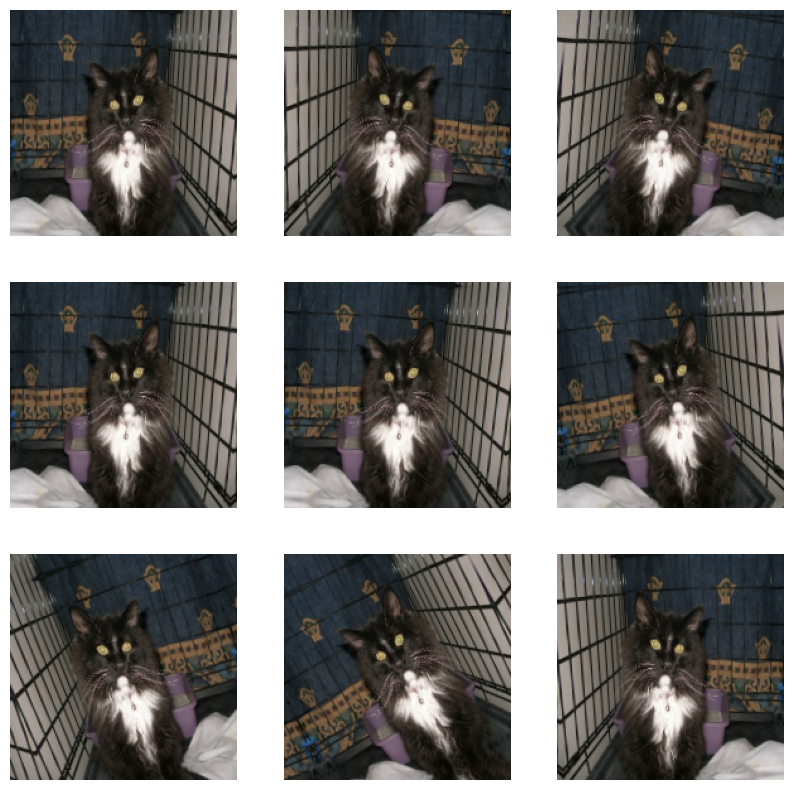

In [101]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

## Standardizing the data

Our image are already in a standard size (180x180), as they are being yielded as contiguous float32 batches by our dataset. However, their RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, we will standardize values to be in the [0, 1] by using a Rescaling layer at the start of our model.

### Two options to preprocess the data

There are two ways you could be using the data_augmentation preprocessor:

**Option 1: Make it part of the model**, like this:

```python
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
...  # Rest of the model
```

With this option, your data augmentation will happen on device, synchronously with the rest of the model execution, meaning that it will benefit from GPU acceleration.

Note that data augmentation is inactive at test time, so the input samples will only be augmented during fit(), not when calling evaluate() or predict().

If you're training on GPU, this may be a good option.

**Option 2: apply it to the dataset**, so as to obtain a dataset that yields batches of augmented images, like this:

```python
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))
```

With this option, your data augmentation will happen on CPU, asynchronously, and will be buffered before going into the model.

If you're training on CPU, this is the better option, since it makes data augmentation asynchronous and non-blocking.

In our case, we'll go with the second option. If you're not sure which one to pick, this second option (asynchronous preprocessing) is always a solid choice.

## Configure the dataset for performance

Let's apply data augmentation to our training dataset, and let's make sure to use buffered prefetching so we can yield data from disk without having I/O becoming blocking:

In [102]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)

# Skip any rare unreadable image records instead of crashing during fit().
train_ds = train_ds.ignore_errors()
val_ds = val_ds.ignore_errors()

# Prefetching samples in memory helps pipeline throughput.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

## Build a model

We'll build a small version of the Xception network. We haven't particularly tried to optimize the architecture; if you want to do a systematic search for the best model configuration, consider using KerasTuner.

Note that:

- We start the model with the data_augmentation preprocessor, followed by a Rescaling layer.
- We include a Dropout layer before the final classification layer.

In [103]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Image augmentation block (This makes it slower on CPU, but helps accuracy)
    # x = data_augmentation(inputs)  
    # To speed up training heavily, we can skip augmentation inside the model
    # and just rely on the pre-processing map we did earlier, or disable it.
    
    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Simple Block 1
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # Simple Block 2
    x = layers.Conv2D(128, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # Global pooling
    x = layers.GlobalAveragePooling2D()(x)
    
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)

## Train the model

In [ ]:
import os
import time
from datetime import datetime
from IPython.display import clear_output

# Reduce noisy C++/decoder logs in output view.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# Epoch takes my mac bout 3.5 mins
epochs = 100


def fmt_duration(seconds):
    seconds = max(0, int(seconds))
    h, rem = divmod(seconds, 3600)
    m, s = divmod(rem, 60)
    if h > 0:
        return f"{h:02d}:{m:02d}:{s:02d}"
    return f"{m:02d}:{s:02d}"


def fmt_clock_from_now(seconds):
    target = datetime.fromtimestamp(time.time() + max(0, seconds))
    return target.strftime("%I:%M:%S %p")


class TimeLimitCallback(keras.callbacks.Callback):
    def __init__(self, max_seconds):
        super().__init__()
        self.max_seconds = max_seconds
        self.start_time = None

    def on_train_begin(self, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        elapsed = time.time() - self.start_time
        if elapsed >= self.max_seconds:
            print(f"\nStopping training: reached time limit of {self.max_seconds / 3600:.1f} hours.")
            self.model.stop_training = True


class LiveProgressCallback(keras.callbacks.Callback):
    def __init__(self, total_epochs, steps_per_epoch, bar_width=32):
        super().__init__()
        self.total_epochs = int(total_epochs)
        self.steps_per_epoch = int(steps_per_epoch)
        self.bar_width = bar_width
        self.total_steps_all = self.total_epochs * self.steps_per_epoch
        self.train_start = None
        self.epoch_start = None
        self.current_epoch = 0
        self.last_epoch_summary = ""

    def _render_bar(self, current, total):
        ratio = min(max(current / max(total, 1), 0.0), 1.0)
        filled = int(ratio * self.bar_width)
        return "[" + ("#" * filled) + ("-" * (self.bar_width - filled)) + "]"

    def on_train_begin(self, logs=None):
        self.train_start = time.time()

    def on_epoch_begin(self, epoch, logs=None):
        self.current_epoch = epoch
        self.epoch_start = time.time()

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        now = time.time()

        steps_done = min(batch + 1, self.steps_per_epoch)
        epoch_elapsed = now - self.epoch_start
        total_elapsed = now - self.train_start

        epoch_step_time = epoch_elapsed / max(steps_done, 1)
        epoch_remaining = (self.steps_per_epoch - steps_done) * epoch_step_time

        completed_steps_all = self.current_epoch * self.steps_per_epoch + steps_done
        total_step_time = total_elapsed / max(completed_steps_all, 1)
        total_remaining = (self.total_steps_all - completed_steps_all) * total_step_time

        epoch_bar = self._render_bar(steps_done, self.steps_per_epoch)
        total_bar = self._render_bar(completed_steps_all, self.total_steps_all)

        progress_epoch = f"Epoch {self.current_epoch + 1}/{self.total_epochs} {epoch_bar} {steps_done}/{self.steps_per_epoch}"
        progress_total = f"Total progress         {total_bar} {completed_steps_all}/{self.total_steps_all}"

        epoch_time_line = (
            f"Epoch elapsed: {fmt_duration(epoch_elapsed)} | "
            f"Epoch ETA: {fmt_duration(epoch_remaining)} | "
            f"Epoch completion: {fmt_clock_from_now(epoch_remaining)}"
        )
        total_time_line = (
            f"Total elapsed: {fmt_duration(total_elapsed)} | "
            f"Total ETA: {fmt_duration(total_remaining)} | "
            f"Training completion: {fmt_clock_from_now(total_remaining)}"
        )

        loss_val = logs.get("loss")
        acc_val = logs.get("acc")
        metrics_line = ""
        if loss_val is not None or acc_val is not None:
            parts = []
            if loss_val is not None:
                parts.append(f"loss: {loss_val:.4f}")
            if acc_val is not None:
                parts.append(f"acc: {acc_val:.4f}")
            metrics_line = " | ".join(parts)

        clear_output(wait=True)
        print("Training Progress")
        print(progress_epoch)
        print(progress_total)
        print(epoch_time_line)
        print(total_time_line)
        if metrics_line:
            print(metrics_line)
        if self.last_epoch_summary:
            print("")
            print(self.last_epoch_summary)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        loss_val = logs.get("loss")
        acc_val = logs.get("acc")
        val_loss = logs.get("val_loss")
        val_acc = logs.get("val_acc")

        parts = [f"Epoch {epoch + 1} complete"]
        if loss_val is not None:
            parts.append(f"loss: {loss_val:.4f}")
        if acc_val is not None:
            parts.append(f"acc: {acc_val:.4f}")
        if val_loss is not None:
            parts.append(f"val_loss: {val_loss:.4f}")
        if val_acc is not None:
            parts.append(f"val_acc: {val_acc:.4f}")
        self.last_epoch_summary = " | ".join(parts)


# Ensure we have concrete step counts so progress + ETA always render.
steps_per_epoch = int(tf.data.experimental.cardinality(train_ds).numpy())
validation_steps = int(tf.data.experimental.cardinality(val_ds).numpy())

callbacks = [
    LiveProgressCallback(total_epochs=epochs, steps_per_epoch=steps_per_epoch),
    keras.callbacks.ModelCheckpoint(
        "cats_dogs_best.keras",
        monitor="val_loss",
        save_best_only=True,
        mode="min",
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=8,
        restore_best_weights=True,
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1,
    ),
    TimeLimitCallback(max_seconds=7.5 * 60 * 60),  # Seven and a half hours
]

model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

# Train the model
model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    callbacks=callbacks,
    validation_data=val_ds,
    validation_steps=validation_steps,
    verbose=0,
)

Training Progress
Epoch 1/100 [--------------------------------] -2/-2
Total progress         [--------------------------------] -2/-200
Epoch elapsed: 00:24 | Epoch ETA: 00:00 | Epoch completion: 05:38:08 PM
Total elapsed: 00:24 | Total ETA: 00:00 | Training completion: 05:38:08 PM
loss: 0.5920 | acc: 0.6715


We get to >90% validation accuracy after training for 25 epochs on the full dataset (in practice, you can train for 50+ epochs before validation performance starts degrading).

## Run inference on new data

Note that data augmentation and dropout are inactive at inference time.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
This image is 79.90% cat and 20.10% dog.


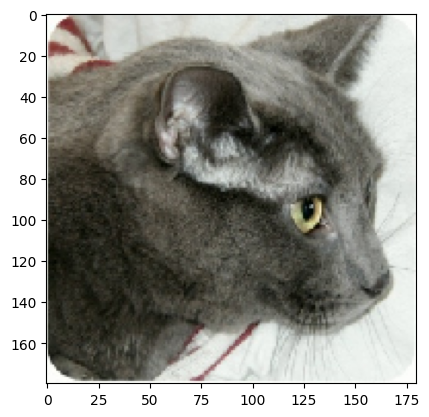

In [ ]:
img = keras.utils.load_img(str(DATA_DIR / "Cat" / "6779.jpg"), target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

In [ ]:
# Keep only the best checkpoint and remove other .keras files in notebook folder
best_model_name = "cats_dogs_best.keras"
removed = []

for fpath in NOTEBOOK_DIR.glob("*.keras"):
    if fpath.name != best_model_name:
        os.remove(fpath)
        removed.append(fpath.name)

best_model_path = NOTEBOOK_DIR / best_model_name
if best_model_path.exists():
    print(f"Kept: {best_model_path}")
else:
    print(f"Warning: {best_model_path} was not found.")

if removed:
    print("Removed:")
    for fname in removed:
        print(f"- {fname}")
else:
    print("No other .keras files to remove.")

Model saved as 'cats_dogs_model.keras'
